In [1]:
import random
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
import keras as k
import keras.backend as K
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras

In [2]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
df = pd.read_csv('../../data/mcar_10.csv',  index_col=0)
original = pd.read_csv('../../data/original.csv',  index_col=0)
gene_info = pd.read_csv('../../data/gene_info.csv',  index_col=0)

In [3]:
param = np.array(gene_info['param'])


X = np.array(df.T)  
n_dims = X.shape[1]
original = original.T

means = original.mean(axis = 1)
means2 = [0 if x < means.mean() else 1 for x in means]

latent_dim = 2

In [4]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def fill(self, missing_mask):
  self.data[missing_mask] = -1


def create_missing_mask(X):
  if X.dtype != "f" and X.dtype != "d":
      X = X.astype(float)
  return np.isnan(X.data)


def bool_to_binary(matrix):

  binary_matrix = []
  for row in matrix:
      binary_row = []
      for value in row:
          binary_row.append(1 if value else 0)
      binary_matrix.append(binary_row)
  return binary_matrix


def replace_nan(data, replacement):


  if not isinstance(data, np.ndarray):
      raise ValueError("Unsupported data type. Function supports numpy arrays only.")

  data[np.isnan(data)] = replacement

  return data


In [5]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])


In [6]:
def reconstruction(input_and_mask, y_pred):
    input_and_mask = input_and_mask
    X_values = input_and_mask[:, :n_dims]

    missing_mask = input_and_mask[:, n_dims:]

    observed_mask = 1 - missing_mask

    X_values_observed = X_values * observed_mask

    pred_observed = y_pred * observed_mask

    mse = K.sum(K.square(pred_observed - X_values_observed) * K.cast(K.not_equal(X_values_observed, 0), K.floatx())) / K.maximum(K.sum(K.cast(K.not_equal(X_values_observed, 0), K.floatx())), 1)
    #mse = K.mean(K.square(X_values_observed * K.cast(K.not_equal(X_values_observed, 0), K.floatx()) - pred_observed), axis=-1)


    return mse

In [7]:
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = n_dims
latent_dim = 2 # 

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    x_mean, x_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon

In [8]:
K.clear_session()

# Variational autoencoder model
input_img = keras.layers.Input(shape=(original_dim*2,))
condition = keras.layers.Input(shape = (1,))
conditional = keras.layers.Concatenate()([input_img, condition])
encoded = keras.layers.Dense(64)(conditional)
encoded = keras.layers.Dense(16)(encoded)
x_mean = keras.layers.Dense(latent_dim)(encoded)
x_log_var = keras.layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

x = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
x = keras.layers.Concatenate()([x,condition])
# at this point the representation has dimension: latent_dim 

decoded = keras.layers.Dense(16)(x)
decoded = keras.layers.Dense(64)(decoded)
decoded = keras.layers.Dense(original_dim, activation='linear')(decoded)
vae = keras.Model([input_img,condition], decoded, name='vae')
#print (vae.summary())



2023-04-12 13:59:39.081463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Create the loss function and compile the model
# The loss function as defined by paper Kingma

reconstruction_loss = original_dim * reconstruction(input_img, decoded)  
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation 

# encoder model (first part of the variotional autoencoder) 
encoder = keras.Model([input_img,condition], [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)

In [10]:
vae.fit([input_with_mask,means],input_with_mask,
        shuffle=True,
        epochs=3000,
        batch_size=32,
        #validation_split= 0.2,
        #callbacks=[early_stop]
       )

Epoch 1/3000
10/10 [==============================] - 0s 1ms/step - loss: 3825.6711
Epoch 2/3000
10/10 [==============================] - 0s 1ms/step - loss: 2923.1909
Epoch 3/3000
10/10 [==============================] - 0s 1ms/step - loss: 1850.7201
Epoch 4/3000
10/10 [==============================] - 0s 1ms/step - loss: 810.6063
Epoch 5/3000
10/10 [==============================] - 0s 1ms/step - loss: 329.1474
Epoch 6/3000
10/10 [==============================] - 0s 1ms/step - loss: 199.7417
Epoch 7/3000
10/10 [==============================] - 0s 1ms/step - loss: 149.6530
Epoch 8/3000
10/10 [==============================] - 0s 1ms/step - loss: 128.5089
Epoch 9/3000
10/10 [==============================] - 0s 1ms/step - loss: 119.6320
Epoch 10/3000
10/10 [==============================] - 0s 1ms/step - loss: 105.0722
Epoch 11/3000
10/10 [==============================] - 0s 1ms/step - loss: 97.6684
Epoch 12/3000
10/10 [==============================] - 0s 1ms/step - loss: 90.4236


10/10 [==============================] - 0s 1ms/step - loss: 33.9288
Epoch 100/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.9543
Epoch 101/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.7227
Epoch 102/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.2340
Epoch 103/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.3658
Epoch 104/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.6567
Epoch 105/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.5112
Epoch 106/3000
10/10 [==============================] - 0s 1ms/step - loss: 32.8489
Epoch 107/3000
10/10 [==============================] - 0s 1ms/step - loss: 32.9668
Epoch 108/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.4416
Epoch 109/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.0750
Epoch 110/3000
10/10 [==============================] - 0s 1ms/step - loss: 33.3737
Epoch 1

10/10 [==============================] - 0s 1ms/step - loss: 31.5401
Epoch 197/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.6224
Epoch 198/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.0065
Epoch 199/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.6180
Epoch 200/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.2366
Epoch 201/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.6981
Epoch 202/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.3915
Epoch 203/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.9701
Epoch 204/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.1914
Epoch 205/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.7878
Epoch 206/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.4314
Epoch 207/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.4415
Epoch 2

10/10 [==============================] - 0s 1ms/step - loss: 30.1982
Epoch 294/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.6564
Epoch 295/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.3025
Epoch 296/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.0566
Epoch 297/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.2718
Epoch 298/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.0798
Epoch 299/3000
10/10 [==============================] - 0s 1ms/step - loss: 31.0100
Epoch 300/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.2075
Epoch 301/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2931
Epoch 302/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.0216
Epoch 303/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.1794
Epoch 304/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.6570
Epoch 3

10/10 [==============================] - 0s 1ms/step - loss: 29.7464
Epoch 391/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4982
Epoch 392/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8587
Epoch 393/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.7939
Epoch 394/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1770
Epoch 395/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0281
Epoch 396/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5259
Epoch 397/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.0921
Epoch 398/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5470
Epoch 399/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.9470
Epoch 400/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.0656
Epoch 401/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5848
Epoch 4

10/10 [==============================] - 0s 1ms/step - loss: 28.9953
Epoch 488/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4701
Epoch 489/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2699
Epoch 490/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5525
Epoch 491/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0118
Epoch 492/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.6685
Epoch 493/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8742
Epoch 494/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.1742
Epoch 495/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3688
Epoch 496/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5398
Epoch 497/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5405
Epoch 498/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.7069
Epoch 4

10/10 [==============================] - 0s 1ms/step - loss: 28.8895
Epoch 585/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5868
Epoch 586/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3262
Epoch 587/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0244
Epoch 588/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5625
Epoch 589/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0317
Epoch 590/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1353
Epoch 591/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2461
Epoch 592/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2444
Epoch 593/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0159
Epoch 594/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6989
Epoch 595/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5502
Epoch 5

10/10 [==============================] - 0s 1ms/step - loss: 29.0960
Epoch 682/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1779
Epoch 683/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4196
Epoch 684/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3822
Epoch 685/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.7391
Epoch 686/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2948
Epoch 687/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8276
Epoch 688/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5969
Epoch 689/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2286
Epoch 690/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5930
Epoch 691/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8995
Epoch 692/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9834
Epoch 6

10/10 [==============================] - 0s 1ms/step - loss: 28.2593
Epoch 779/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.7468
Epoch 780/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7255
Epoch 781/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3856
Epoch 782/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.8471
Epoch 783/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0859
Epoch 784/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9528
Epoch 785/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9872
Epoch 786/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0916
Epoch 787/3000
10/10 [==============================] - 0s 1ms/step - loss: 30.3512
Epoch 788/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0131
Epoch 789/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1730
Epoch 7

10/10 [==============================] - 0s 1ms/step - loss: 28.9892
Epoch 876/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8695
Epoch 877/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4746
Epoch 878/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0124
Epoch 879/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.6462
Epoch 880/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8211
Epoch 881/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2036
Epoch 882/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6894
Epoch 883/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8818
Epoch 884/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5115
Epoch 885/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4806
Epoch 886/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3124
Epoch 8

10/10 [==============================] - 0s 1ms/step - loss: 28.0370
Epoch 973/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6663
Epoch 974/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1700
Epoch 975/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1438
Epoch 976/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2413
Epoch 977/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1472
Epoch 978/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7229
Epoch 979/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9269
Epoch 980/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8044
Epoch 981/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6397
Epoch 982/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4967
Epoch 983/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1849
Epoch 9

10/10 [==============================] - 0s 1ms/step - loss: 29.1324
Epoch 1069/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5485
Epoch 1070/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5734
Epoch 1071/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0253
Epoch 1072/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2685
Epoch 1073/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0230
Epoch 1074/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2613
Epoch 1075/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5688
Epoch 1076/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2606
Epoch 1077/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0977
Epoch 1078/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4425
Epoch 1079/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1

10/10 [==============================] - 0s 1ms/step - loss: 28.8482
Epoch 1165/3000
10/10 [==============================] - 0s 2ms/step - loss: 28.2581
Epoch 1166/3000
10/10 [==============================] - 0s 2ms/step - loss: 28.8210
Epoch 1167/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8522
Epoch 1168/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0619
Epoch 1169/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6722
Epoch 1170/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9388
Epoch 1171/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3476
Epoch 1172/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5307
Epoch 1173/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8131
Epoch 1174/3000
10/10 [==============================] - 0s 3ms/step - loss: 28.5411
Epoch 1175/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4

10/10 [==============================] - 0s 1ms/step - loss: 29.3320
Epoch 1261/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9282
Epoch 1262/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9282
Epoch 1263/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6997
Epoch 1264/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3093
Epoch 1265/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7305
Epoch 1266/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5634
Epoch 1267/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9702
Epoch 1268/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4046
Epoch 1269/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4294
Epoch 1270/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6962
Epoch 1271/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5

10/10 [==============================] - 0s 1ms/step - loss: 28.3498
Epoch 1357/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8189
Epoch 1358/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8558
Epoch 1359/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2079
Epoch 1360/3000
10/10 [==============================] - 0s 2ms/step - loss: 28.3035
Epoch 1361/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8720
Epoch 1362/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8342
Epoch 1363/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3888
Epoch 1364/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1816
Epoch 1365/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4273
Epoch 1366/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7070
Epoch 1367/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4

10/10 [==============================] - 0s 1ms/step - loss: 29.1241
Epoch 1453/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8138
Epoch 1454/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0364
Epoch 1455/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5024
Epoch 1456/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0693
Epoch 1457/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7747
Epoch 1458/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1239
Epoch 1459/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1545
Epoch 1460/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7279
Epoch 1461/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.4482
Epoch 1462/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6291
Epoch 1463/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8

10/10 [==============================] - 0s 1ms/step - loss: 28.9735
Epoch 1549/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6939
Epoch 1550/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0312
Epoch 1551/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3686
Epoch 1552/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2457
Epoch 1553/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1090
Epoch 1554/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8361
Epoch 1555/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2276
Epoch 1556/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9032
Epoch 1557/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9405
Epoch 1558/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8013
Epoch 1559/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0

10/10 [==============================] - 0s 1ms/step - loss: 28.4051
Epoch 1645/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2627
Epoch 1646/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9082
Epoch 1647/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5616
Epoch 1648/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.6736
Epoch 1649/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4905
Epoch 1650/3000
10/10 [==============================] - 0s 998us/step - loss: 28.7155
Epoch 1651/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5660
Epoch 1652/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1170
Epoch 1653/3000
10/10 [==============================] - 0s 976us/step - loss: 28.2304
Epoch 1654/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1091
Epoch 1655/3000
10/10 [==============================] - 0s 1ms/step - loss: 

10/10 [==============================] - 0s 983us/step - loss: 28.9681
Epoch 1741/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3496
Epoch 1742/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6736
Epoch 1743/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5351
Epoch 1744/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8491
Epoch 1745/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2871
Epoch 1746/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1288
Epoch 1747/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3827
Epoch 1748/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5067
Epoch 1749/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0275
Epoch 1750/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5328
Epoch 1751/3000
10/10 [==============================] - 0s 1ms/step - loss: 28

10/10 [==============================] - 0s 1ms/step - loss: 28.6545
Epoch 1837/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5991
Epoch 1838/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1753
Epoch 1839/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0106
Epoch 1840/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3075
Epoch 1841/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8434
Epoch 1842/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5581
Epoch 1843/3000
10/10 [==============================] - 0s 1000us/step - loss: 28.6504
Epoch 1844/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5369
Epoch 1845/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2872
Epoch 1846/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8960
Epoch 1847/3000
10/10 [==============================] - 0s 1ms/step - loss: 2

10/10 [==============================] - 0s 953us/step - loss: 28.6197
Epoch 1933/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6688
Epoch 1934/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0949
Epoch 1935/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2284
Epoch 1936/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5516
Epoch 1937/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8213
Epoch 1938/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4720
Epoch 1939/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6631
Epoch 1940/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0494
Epoch 1941/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.9709
Epoch 1942/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2103
Epoch 1943/3000
10/10 [==============================] - 0s 1ms/step - loss: 28

10/10 [==============================] - 0s 1ms/step - loss: 28.6964
Epoch 2029/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0787
Epoch 2030/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9299
Epoch 2031/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2546
Epoch 2032/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4176
Epoch 2033/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4203
Epoch 2034/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9222
Epoch 2035/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9986
Epoch 2036/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.9924
Epoch 2037/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4176
Epoch 2038/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5262
Epoch 2039/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6

10/10 [==============================] - 0s 1ms/step - loss: 28.7403
Epoch 2125/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6693
Epoch 2126/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5869
Epoch 2127/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4772
Epoch 2128/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9938
Epoch 2129/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9720
Epoch 2130/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3768
Epoch 2131/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.9043
Epoch 2132/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5859
Epoch 2133/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5126
Epoch 2134/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2859
Epoch 2135/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2

10/10 [==============================] - 0s 1ms/step - loss: 28.7007
Epoch 2221/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8267
Epoch 2222/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4561
Epoch 2223/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9569
Epoch 2224/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6246
Epoch 2225/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4952
Epoch 2226/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6387
Epoch 2227/3000
10/10 [==============================] - 0s 995us/step - loss: 28.4719
Epoch 2228/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4725
Epoch 2229/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4997
Epoch 2230/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4678
Epoch 2231/3000
10/10 [==============================] - 0s 1ms/step - loss: 28

10/10 [==============================] - 0s 1ms/step - loss: 28.2432
Epoch 2317/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9157
Epoch 2318/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7825
Epoch 2319/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2226
Epoch 2320/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.5001
Epoch 2321/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0658
Epoch 2322/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1496
Epoch 2323/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2823
Epoch 2324/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5878
Epoch 2325/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3443
Epoch 2326/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4903
Epoch 2327/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0

10/10 [==============================] - 0s 1ms/step - loss: 28.9689
Epoch 2413/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0198
Epoch 2414/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8960
Epoch 2415/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2852
Epoch 2416/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8681
Epoch 2417/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8940
Epoch 2418/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6909
Epoch 2419/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2021
Epoch 2420/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7001
Epoch 2421/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0635
Epoch 2422/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4214
Epoch 2423/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9

10/10 [==============================] - 0s 1ms/step - loss: 28.2476
Epoch 2509/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7203
Epoch 2510/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0471
Epoch 2511/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0847
Epoch 2512/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1212
Epoch 2513/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.3642
Epoch 2514/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1857
Epoch 2515/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.9337
Epoch 2516/3000
10/10 [==============================] - 0s 2ms/step - loss: 28.1958
Epoch 2517/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4177
Epoch 2518/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3577
Epoch 2519/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4

10/10 [==============================] - 0s 1ms/step - loss: 28.0485
Epoch 2605/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4364
Epoch 2606/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0250
Epoch 2607/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2793
Epoch 2608/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7364
Epoch 2609/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0682
Epoch 2610/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1265
Epoch 2611/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5022
Epoch 2612/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2019
Epoch 2613/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7140
Epoch 2614/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9359
Epoch 2615/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3

10/10 [==============================] - 0s 1ms/step - loss: 28.3150
Epoch 2701/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8019
Epoch 2702/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6506
Epoch 2703/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0952
Epoch 2704/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4618
Epoch 2705/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.8757
Epoch 2706/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4437
Epoch 2707/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3370
Epoch 2708/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4807
Epoch 2709/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0641
Epoch 2710/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9451
Epoch 2711/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.3

10/10 [==============================] - 0s 1ms/step - loss: 28.4806
Epoch 2797/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1778
Epoch 2798/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1831
Epoch 2799/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2242
Epoch 2800/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7299
Epoch 2801/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5964
Epoch 2802/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7177
Epoch 2803/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.2586
Epoch 2804/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.9333
Epoch 2805/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7963
Epoch 2806/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0432
Epoch 2807/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7

10/10 [==============================] - 0s 1ms/step - loss: 29.0460
Epoch 2893/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1629
Epoch 2894/3000
10/10 [==============================] - 0s 996us/step - loss: 28.4313
Epoch 2895/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0403
Epoch 2896/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.1772
Epoch 2897/3000
10/10 [==============================] - 0s 981us/step - loss: 28.0889
Epoch 2898/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7488
Epoch 2899/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7410
Epoch 2900/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.1692
Epoch 2901/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.0706
Epoch 2902/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6005
Epoch 2903/3000
10/10 [==============================] - 0s 1ms/step - loss: 

10/10 [==============================] - 0s 1ms/step - loss: 28.9027
Epoch 2989/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5994
Epoch 2990/3000
10/10 [==============================] - 0s 1ms/step - loss: 27.8469
Epoch 2991/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.7934
Epoch 2992/3000
10/10 [==============================] - 0s 1ms/step - loss: 29.2438
Epoch 2993/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.6904
Epoch 2994/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.4180
Epoch 2995/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5098
Epoch 2996/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.0949
Epoch 2997/3000
10/10 [==============================] - 0s 973us/step - loss: 28.4767
Epoch 2998/3000
10/10 [==============================] - 0s 1ms/step - loss: 28.5816
Epoch 2999/3000
10/10 [==============================] - 0s 973us/step - loss: 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Y = vae.predict([input_with_mask,means])



imputed = pd.DataFrame(Y)
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(imputed))
scaler2 = StandardScaler()
original2 = pd.DataFrame(scaler2.fit_transform(original.T))


# generate boolean mask for missing values
masked = df2.T.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = z_scores.iloc[missing_indexes].values.flatten()
orignal_values = original2.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

In [11]:
embedding = encoder.predict([input_with_mask,means])[0]

10/10 [==============================] - 0s 684us/step


In [ ]:
my_array = np.array(embedding)

print(my_array.shape)

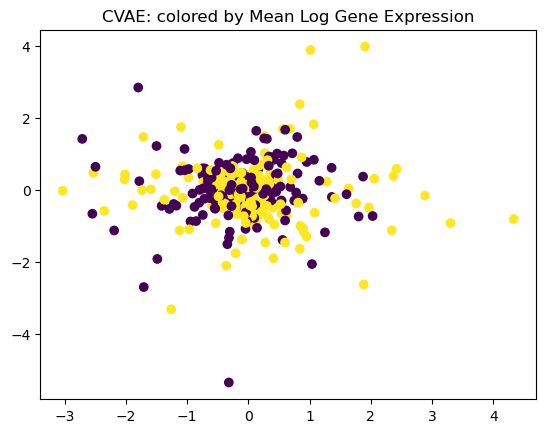

In [12]:
plt.scatter(embedding[:, 0], embedding[:, 1], c= means2)
plt.title('CVAE: colored by Mean Log Gene Expression')
plt.show()

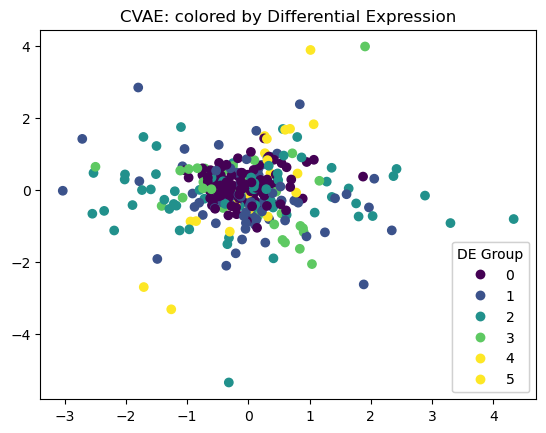

In [13]:
# create color map
cmap = plt.cm.get_cmap('viridis', 5)

# plot scatter plot with colored points
fig, ax = plt.subplots()
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=param, cmap=cmap)

# create legend
legend1 = ax.legend(*scatter.legend_elements(), loc='lower right', title="DE Group")
ax.add_artist(legend1)
plt.title('CVAE: colored by Differential Expression')

plt.show()



In [ ]:
plt.scatter(imputed_values, orignal_values)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('CVAE')
plt.show()

# Scaled Data

In [ ]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
scaled = pd.read_csv('../../data/mcar_scaled.csv',  index_col=0)
scaled = np.array(scaled.T)  
n_dims = scaled.shape[1]

In [ ]:
mask = np.array(bool_to_binary(create_missing_mask(scaled)))
X_no_na = replace_nan(scaled, replacement = 1)
scaled_with_mask = np.hstack([X_no_na, mask])


In [ ]:
vae.fit([scaled_with_mask,means],scaled_with_mask,
        epochs=500,
        batch_size=32)

In [ ]:
embedding = encoder.predict([scaled_with_mask, means])[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c=gene_y)
plt.show()